In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import when



In [3]:
# Initialize Spark Session
spark = SparkSession.builder.appName("CrashRecordsEDA").getOrCreate()

# Load data
df = spark.read.csv("cleaned_traffic_crashes.csv", header=True, inferSchema=True)



In [4]:
# Print the schema
df.printSchema()

# Count the number of rows
print(f"Number of rows: {df.count()}")

# Show summary statistics
df.describe().show()


root
 |-- _c0: integer (nullable = true)
 |-- CRASH_RECORD_ID: string (nullable = true)
 |-- RD_NO: string (nullable = true)
 |-- CRASH_DATE: string (nullable = true)
 |-- POSTED_SPEED_LIMIT: integer (nullable = true)
 |-- TRAFFIC_CONTROL_DEVICE: string (nullable = true)
 |-- DEVICE_CONDITION: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- TRAFFICWAY_TYPE: string (nullable = true)
 |-- ALIGNMENT: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- ROAD_DEFECT: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- DAMAGE: string (nullable = true)
 |-- DATE_POLICE_NOTIFIED: string (nullable = true)
 |-- PRIM_CONTRIBUTORY_CAUSE: string (nullable = true)
 |-- SEC_CONTRIBUTORY_CAUSE: string (nullable = true)
 |-- STREET_NO: integer (nullable = true)
 |-- STREET_DIRECTION: s

+----------+-----+
|CRASH_HOUR|count|
+----------+-----+
|         0|16917|
|         1|14449|
|         2|12434|
|         3|10111|
|         4| 9033|
|         5|10732|
|         6|16958|
|         7|32949|
|         8|41163|
|         9|35846|
|        10|35513|
|        11|39635|
|        12|45874|
|        13|47538|
|        14|52440|
|        15|60293|
|        16|59748|
|        17|58075|
|        18|47969|
|        19|35407|
+----------+-----+
only showing top 20 rows



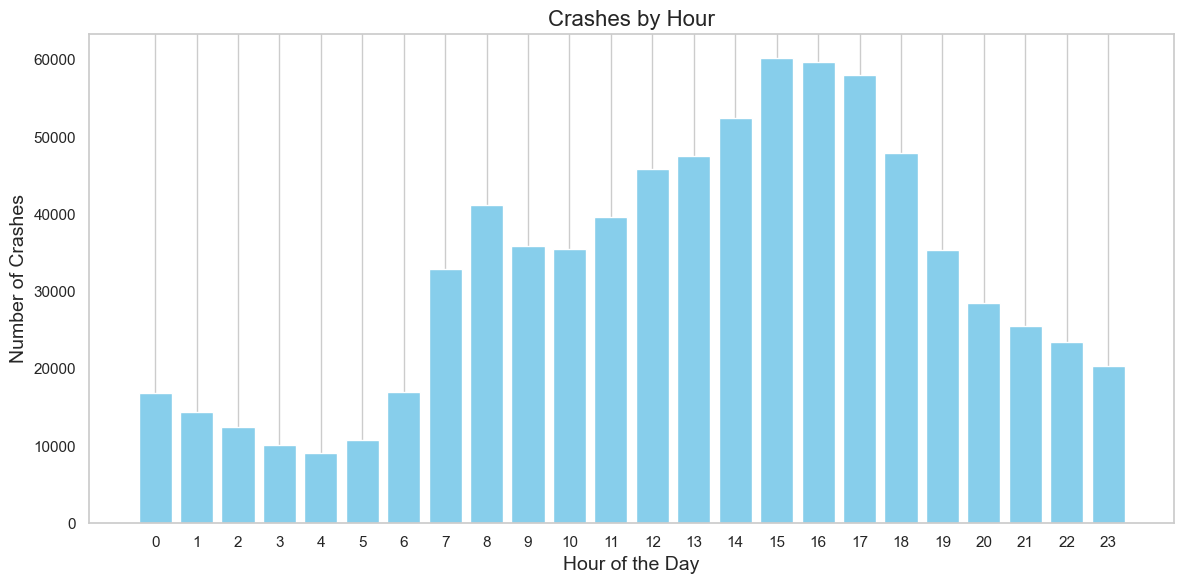

In [5]:
# Distribution of Crashes Over Time

#Crashes by Hour:

from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

crashes_by_hour = df.groupBy("CRASH_HOUR").count().orderBy("CRASH_HOUR")

crashes_by_hour.show()

crashes_by_hour_pd = crashes_by_hour.toPandas()

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.bar(crashes_by_hour_pd['CRASH_HOUR'], crashes_by_hour_pd['count'], color='skyblue')
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.title('Crashes by Hour', fontsize=16)
plt.xticks(range(0, 24))  # Hours from 0 to 23
plt.grid(axis='y')
plt.tight_layout()
plt.show()





+-----------------+------+
|CRASH_DAY_OF_WEEK| count|
+-----------------+------+
|                1| 96933|
|                2|107545|
|                3|111397|
|                4|110688|
|                5|112015|
|                6|126802|
|                7|115591|
+-----------------+------+



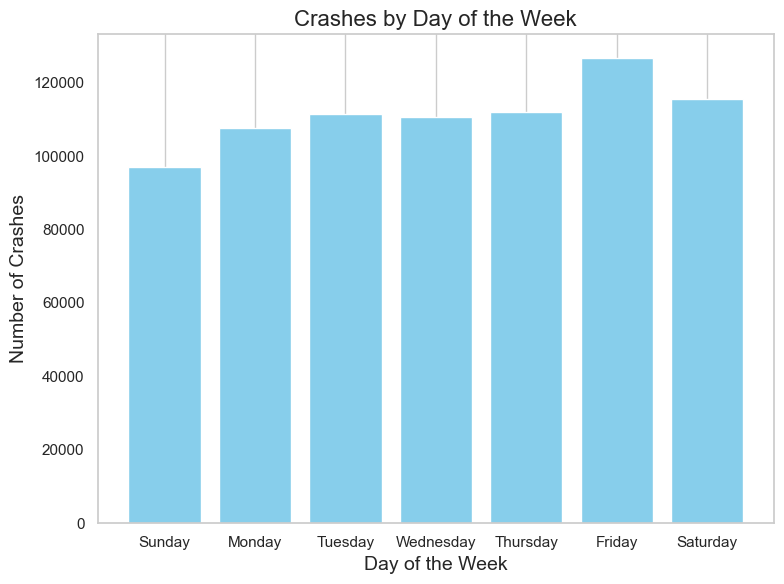

In [6]:

# Distribution of Crashes Over Time

#Crashes by week:

from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

crashes_by_week = df.groupBy("CRASH_DAY_OF_WEEK").count().orderBy("CRASH_DAY_OF_WEEK")

crashes_by_week.show()

crashes_by_week_pd = crashes_by_week.toPandas()

day_names = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
crashes_by_week_pd['CRASH_DAY_OF_WEEK'] = crashes_by_week_pd['CRASH_DAY_OF_WEEK'].map(day_names)

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.bar(crashes_by_week_pd['CRASH_DAY_OF_WEEK'], crashes_by_week_pd['count'], color='skyblue')
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.title('Crashes by Day of the Week', fontsize=16)
plt.xticks(range(0, 7), ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()




+-----------+-----+
|CRASH_MONTH|count|
+-----------+-----+
|          1|57832|
|          2|57481|
|          3|58886|
|          4|57160|
|          5|66527|
|          6|67555|
|          7|68961|
|          8|70892|
|          9|72402|
|         10|76770|
|         11|64791|
|         12|61714|
+-----------+-----+



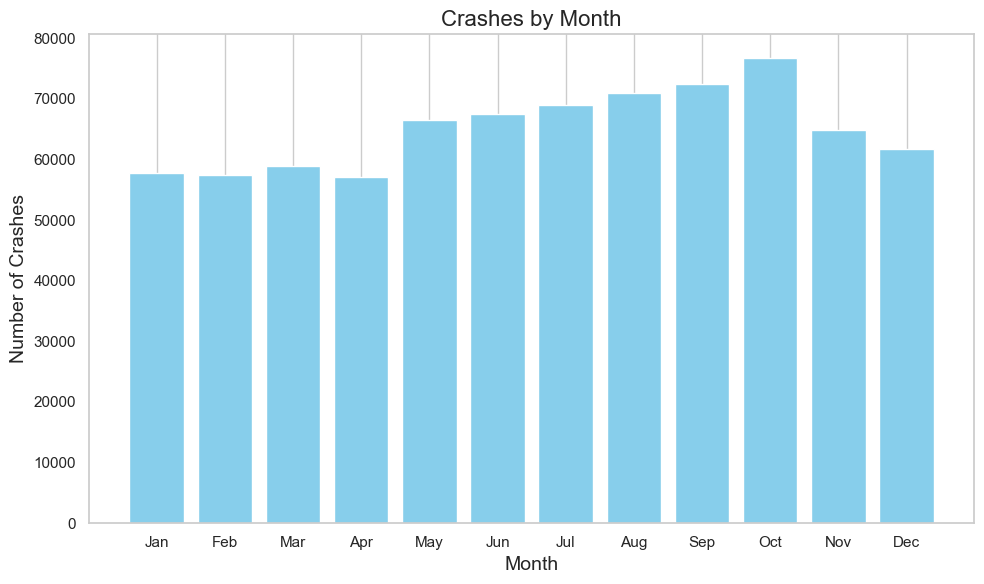

In [7]:

# Distribution of Crashes Over Time

#Crashes by month:

from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

crashes_by_month = df.groupBy("CRASH_MONTH").count().orderBy("CRASH_MONTH")
crashes_by_month.show()
crashes_by_month_pd = crashes_by_month.toPandas()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.bar(crashes_by_month_pd['CRASH_MONTH'], crashes_by_month_pd['count'], color='skyblue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.title('Crashes by Month', fontsize=16)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()




+--------------------+------+
|   WEATHER_CONDITION| count|
+--------------------+------+
|               CLEAR|615466|
|                RAIN| 67468|
|             UNKNOWN| 42084|
|                SNOW| 26624|
|     CLOUDY/OVERCAST| 22910|
|               OTHER|  2407|
|FREEZING RAIN/DRI...|  1407|
|      FOG/SMOKE/HAZE|  1110|
|          SLEET/HAIL|   943|
|        BLOWING SNOW|   398|
|SEVERE CROSS WIND...|   147|
|BLOWING SAND, SOI...|     7|
+--------------------+------+



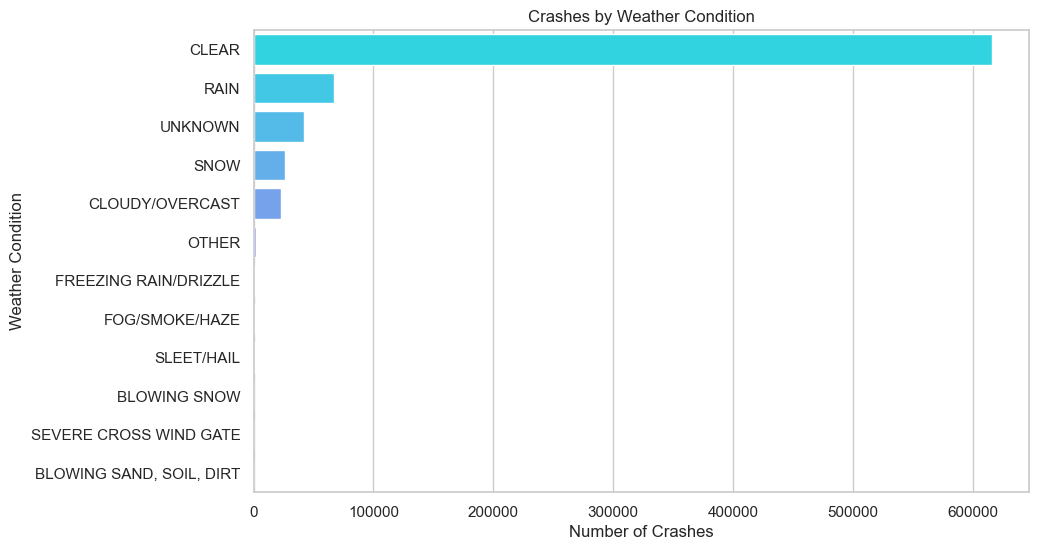

In [10]:
##Catergorical data analysis

import matplotlib.pyplot as plt
import seaborn as sns

weather_crashes = df.groupBy("WEATHER_CONDITION").count().orderBy("count", ascending=False)
weather_crashes.show()
weather_crashes_pd = weather_crashes.toPandas()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="WEATHER_CONDITION", data=weather_crashes_pd, palette="cool")
plt.title("Crashes by Weather Condition")
plt.xlabel("Number of Crashes")
plt.ylabel("Weather Condition")
plt.show()





+----------------------+------+
|TRAFFIC_CONTROL_DEVICE| count|
+----------------------+------+
|           NO CONTROLS|444966|
|        TRAFFIC SIGNAL|216260|
|     STOP SIGN/FLASHER| 77288|
|               UNKNOWN| 30771|
|                 OTHER|  5296|
|      LANE USE MARKING|  1226|
|                 YIELD|  1150|
|       OTHER REG. SIGN|   842|
|    OTHER WARNING SIGN|   641|
|  RAILROAD CROSSING...|   511|
|  PEDESTRIAN CROSSI...|   476|
|           DELINEATORS|   309|
|  FLASHING CONTROL ...|   303|
|           SCHOOL ZONE|   291|
|        POLICE/FLAGMAN|   263|
|  OTHER RAILROAD CR...|   172|
|      RR CROSSING SIGN|   137|
|            NO PASSING|    45|
|  BICYCLE CROSSING ...|    24|
+----------------------+------+



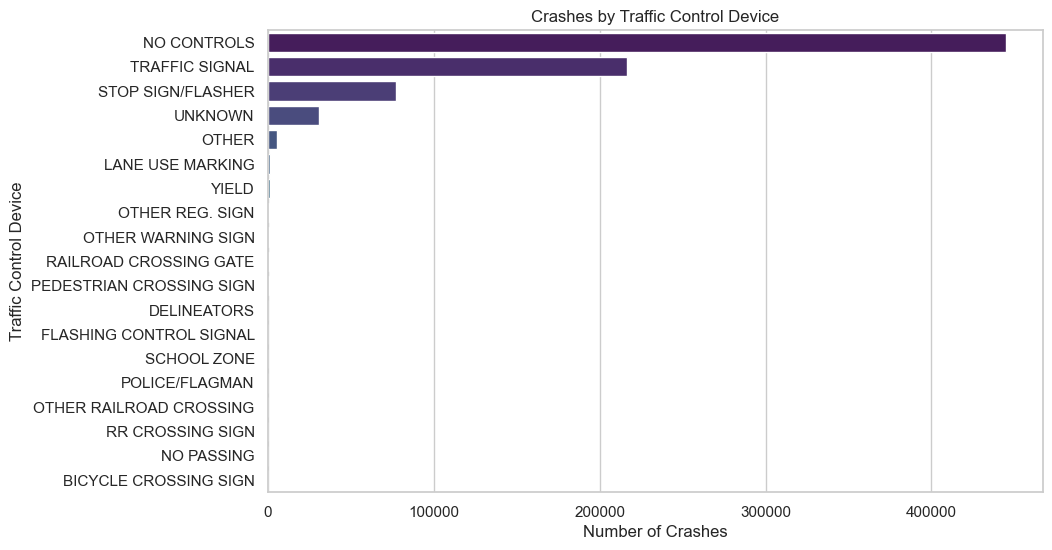

In [11]:
traffic_device_crashes = df.groupBy("TRAFFIC_CONTROL_DEVICE").count().orderBy("count", ascending=False)
traffic_device_crashes.show()
traffic_device_crashes_pd = traffic_device_crashes.toPandas()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="TRAFFIC_CONTROL_DEVICE", data=traffic_device_crashes_pd, palette="viridis")
plt.title("Crashes by Traffic Control Device")
plt.xlabel("Number of Crashes")
plt.ylabel("Traffic Control Device")
plt.show()

+--------------------+------+
|  LIGHTING_CONDITION| count|
+--------------------+------+
|            DAYLIGHT|503302|
|DARKNESS, LIGHTED...|170441|
|            DARKNESS| 36799|
|             UNKNOWN| 35007|
|                DUSK| 22427|
|                DAWN| 12995|
+--------------------+------+



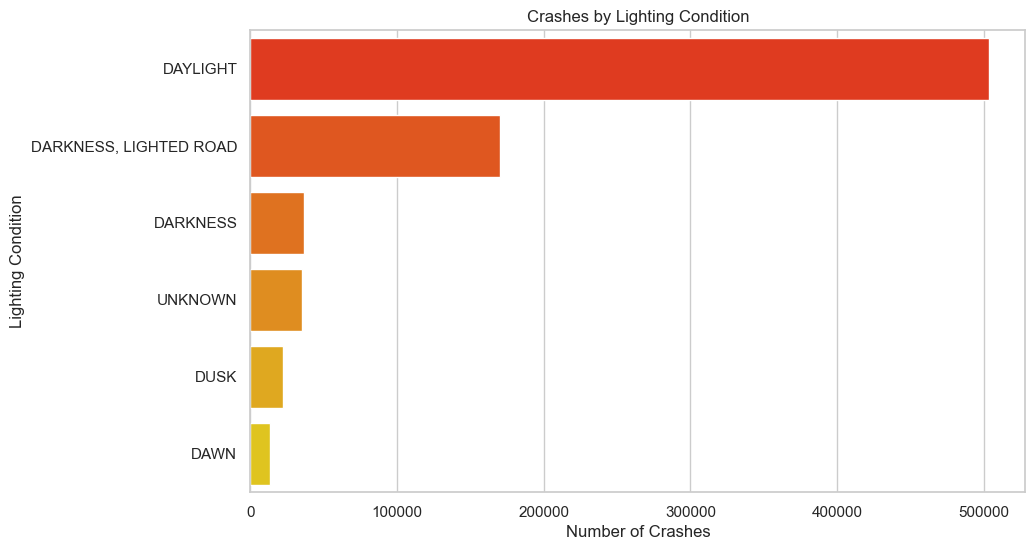

In [12]:

lighting_crashes = df.groupBy("LIGHTING_CONDITION").count().orderBy("count", ascending=False)
lighting_crashes.show()
lighting_crashes_pd = lighting_crashes.toPandas()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="LIGHTING_CONDITION", data=lighting_crashes_pd, palette="autumn")
plt.title("Crashes by Lighting Condition")
plt.xlabel("Number of Crashes")
plt.ylabel("Lighting Condition")
plt.show()

   Fatal Injuries  Incapacitating Injuries  Non-Incapacitating Injuries  \
0           929.0                  15661.0                      83206.0   

   Reported, Not Evident Injuries  No Indication of Injuries  Unknown Injuries  
0                         47398.0                  1562211.0               0.0  


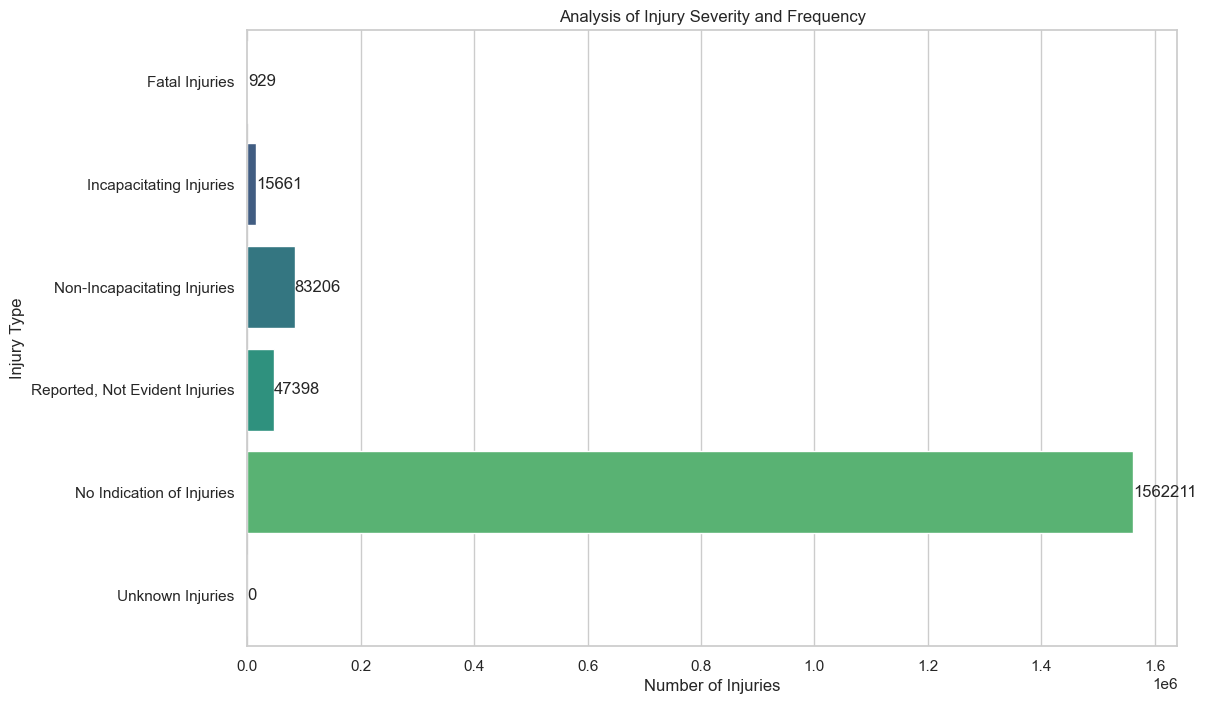

In [13]:
import pyspark.sql.functions as F

injury_analysis = df.select(
    F.sum("INJURIES_FATAL").alias("Fatal Injuries"),
    F.sum("INJURIES_INCAPACITATING").alias("Incapacitating Injuries"),
    F.sum("INJURIES_NON_INCAPACITATING").alias("Non-Incapacitating Injuries"),
    F.sum("INJURIES_REPORTED_NOT_EVIDENT").alias("Reported, Not Evident Injuries"),
    F.sum("INJURIES_NO_INDICATION").alias("No Indication of Injuries"),
    F.sum("INJURIES_UNKNOWN").alias("Unknown Injuries")
)



injury_analysis_pd = injury_analysis.toPandas()
print(injury_analysis_pd)

injury_analysis_pd_transposed = injury_analysis_pd.transpose()
injury_analysis_pd_transposed.columns = ['Number of Injuries']
injury_analysis_pd_transposed.reset_index(inplace=True)
injury_analysis_pd_transposed.rename(columns={'index': 'Injury Type'}, inplace=True)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x="Number of Injuries", y="Injury Type", data=injury_analysis_pd_transposed, palette="viridis")
plt.title("Analysis of Injury Severity and Frequency")
plt.xlabel("Number of Injuries")
plt.ylabel("Injury Type")


for p in barplot.patches:
    width = p.get_width()    
    plt.text(width + 1,      
             p.get_y() + p.get_height() / 2,
             '{:1.0f}'.format(width), 
             ha = 'left',  
             va = 'center') 

plt.show()


In [14]:
## correlation Analysis


from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd


numerical_cols = [column for column, dtype in zip(df.columns, df.dtypes) if dtype[1] in ['int', 'double']]

assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
transformed = assembler.transform(df)

corr_matrix = Correlation.corr(transformed, "features").collect()[0][0]

corr_matrix_df = pd.DataFrame(corr_matrix.toArray(), columns=numerical_cols, index=numerical_cols)


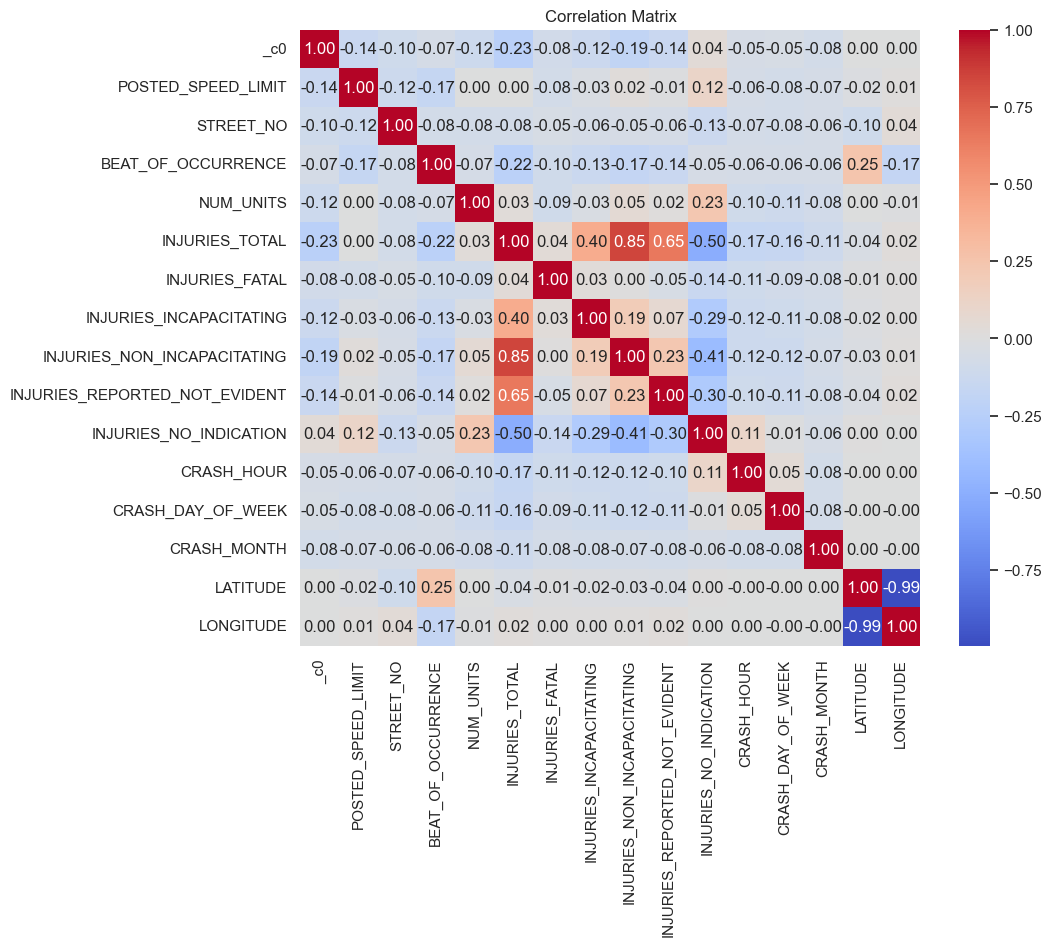

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_data = corr_matrix_df.select_dtypes(include=['float64', 'int64'])

corr_matrix = numerical_data.corr()

corr_matrix_reduced = corr_matrix.drop('INJURIES_UNKNOWN', axis=1).drop('INJURIES_UNKNOWN', axis=0)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_reduced, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [16]:


###Geographical data analyis

In [17]:
pip install geopandas 

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install contextily 


Note: you may need to restart the kernel to use updated packages.


In [19]:
pip install folium 


Note: you may need to restart the kernel to use updated packages.


In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import folium

In [21]:
#the distribution of crashes geographically.


from pyspark.sql.functions import count

df_geo = df.filter(df.LATITUDE.isNotNull() & df.LONGITUDE.isNotNull())

df_geo = df_geo.select("LATITUDE", "LONGITUDE")

location_counts = df_geo.groupBy("LATITUDE", "LONGITUDE").agg(count("*").alias("crash_count"))

top_locations = location_counts.orderBy("crash_count", ascending=False).limit(20)

top_locations_data = top_locations.collect()
top_locations_data

[Row(LATITUDE=41.874710373, LONGITUDE=-87.674052731, crash_count=5243),
 Row(LATITUDE=41.976201139, LONGITUDE=-87.905309125, crash_count=1238),
 Row(LATITUDE=41.900958919, LONGITUDE=-87.619928174, crash_count=717),
 Row(LATITUDE=41.791420282, LONGITUDE=-87.580147769, crash_count=554),
 Row(LATITUDE=41.751460603, LONGITUDE=-87.585971993, crash_count=542),
 Row(LATITUDE=41.722257273, LONGITUDE=-87.585275565, crash_count=423),
 Row(LATITUDE=41.754660124, LONGITUDE=-87.741384759, crash_count=365),
 Row(LATITUDE=41.880856048, LONGITUDE=-87.617635892, crash_count=317),
 Row(LATITUDE=41.789329323, LONGITUDE=-87.741645644, crash_count=304),
 Row(LATITUDE=41.900752974, LONGITUDE=-87.624235, crash_count=286),
 Row(LATITUDE=41.896804972, LONGITUDE=-87.617027423, crash_count=283),
 Row(LATITUDE=41.736209469, LONGITUDE=-87.624305519, crash_count=281),
 Row(LATITUDE=41.92616072, LONGITUDE=-87.631514665, crash_count=275),
 Row(LATITUDE=41.878310135, LONGITUDE=-87.617575903, crash_count=269),
 Row(LAT

In [23]:
# Convert the top locations with crash counts into a format suitable for a heatmap
heat_data = [[row['LATITUDE'], row['LONGITUDE'], row['crash_count']] for row in top_locations_data]
from folium.plugins import HeatMap

# Create a map centered around the first top location
heatmap_map = folium.Map(location=[top_locations_data[0]['LATITUDE'], top_locations_data[0]['LONGITUDE']], 
                               zoom_start=10)

# Create and add a HeatMap layer with weights
HeatMap(heat_data).add_to(heatmap_map)

# Display the heatmap
heatmap_map


In [ ]:
spark.stop()